# Netflix Exploratory Data Analysis
## By: Zachary Delk

Starting off by loading all the data in and checking it out.

In [2]:
# Loading and Inspecting
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Downloading and Storing Dataset
working_path = kagglehub.dataset_download("shivamb/netflix-shows")
file_path = working_path + "/netflix_titles.csv"
df = pd.read_csv(file_path)

# Inspecting Data
print(df.head(3))
print(df.info())

/home/zdelk/workspace/github.com/zdelk/netflix_eda/venv_eda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  show_id     type                 title         director  \
0      s1    Movie  Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show         Blood & Water              NaN   
2      s3  TV Show             Ganglands  Julien Leclercq   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021          2021  TV-MA   1 Season   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   

                

After inspection, time to clean. Replacing 'Not Given' to NaN. Also, converting the strings for 'director', 'cast', 'country', and 'listed_in' into lists of strings. Will make it easier to do further analysis. Since 'listed_in' is equivalent to genres and there is already a column for type of media ('TV Show' or 'Movie'), we can remove those phrases from from the genre substrings. (Also removing the "'" that is left over from "Kids' Tv Show")

In [3]:
# Step 2: Data Cleaning

# Dealing with missing data
df[df == 'Not Given'] = np.nan

# Removing Uneccessary Keywords in Genre
substring_to_remove = ['TV', 'Shows', 'Movies', '\'']
pattern = "|".join(substring_to_remove)
df['listed_in'] = df['listed_in'].str.replace(pattern, "", regex=True)

# Creating list columns for where there are multiple entries
to_split = ['director', 'cast', 'country', 'listed_in']

df_clean = df.copy()

for col in to_split:
    col_name = col + '_list'
    df_clean[col_name] = df[col].str.split(',').apply(
        lambda x: [i.strip() for i in x] if isinstance(x, list) else None
        )


### Q1. What is the most prevalent category?
Started off by isolating genres then getting the counts. Here we can see 'International' is the most prevalent genre with 4103 total entries.

listed_in_list
International         4103
Dramas                3190
Comedies              2255
Action & Adventure    1027
Romantic               986
Documentaries          869
Independent            756
Children & Family      641
Thrillers              634
Crime                  470
Name: count, dtype: int64


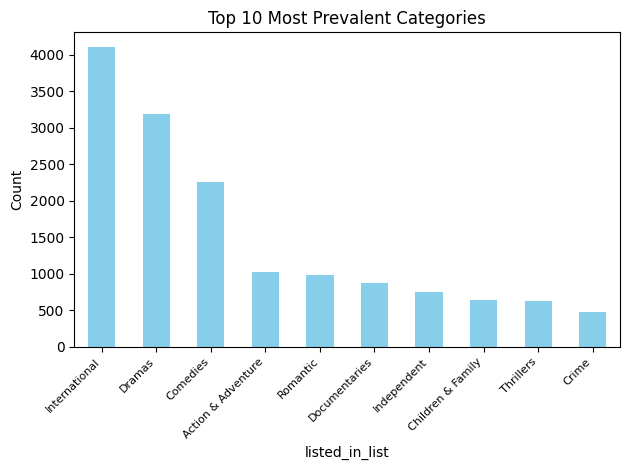

In [4]:
# Q1.What are the most prevalent categories?
# subset_genre = df_clean['listed_in_list'].dropna()
genre_counts = (
    df_clean['listed_in_list']
    .dropna()
    .explode()
    .value_counts()
    .sort_values(ascending=False)
)

top_10_cats = genre_counts[:10]
print(top_10_cats)
# categories, counts = zip(*top_10_cats)
top_10_cats.plot(kind='bar', color = 'skyblue')
plt.title('Top 10 Most Prevalent Categories')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right', fontsize = 8)
plt.tight_layout()

To look a bit deeper we can look at which countries is the content coming from. Looking at only the necessary columns and subsetting to only observations that had 'International' in the columns. Overall it looks like India leads the charge overall and in movies. However South Korea takes the spot by barely beating out Japan when it comes to tv shows.

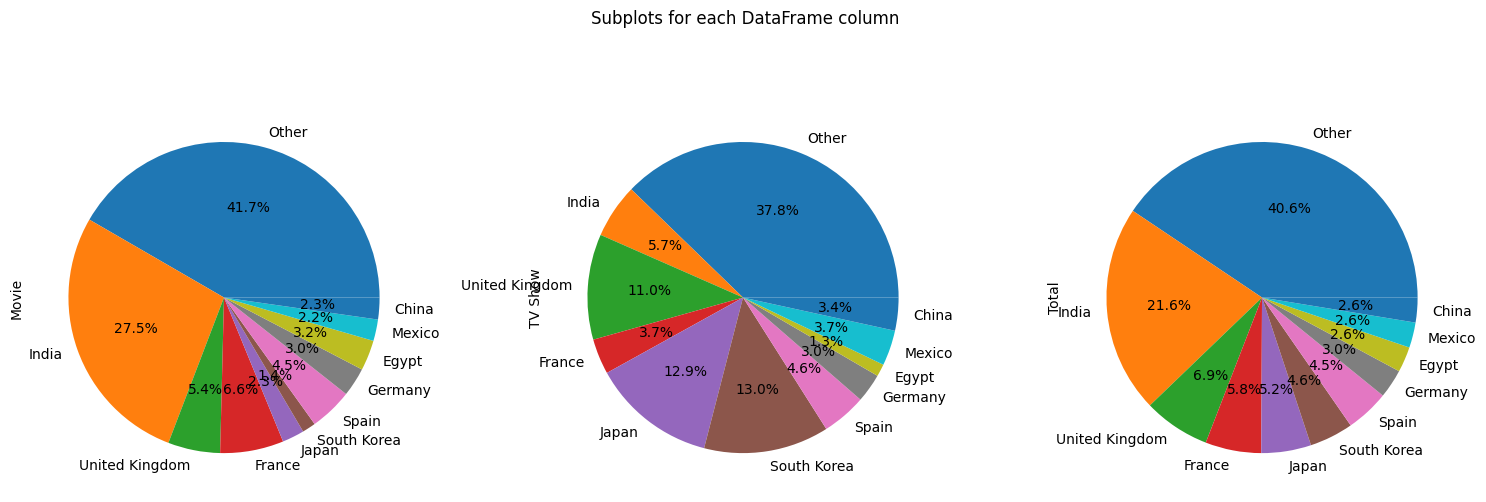

In [5]:
# Looking Deeper into it

# Subset data to just relevant info
# Only worried about entries where 'International' is in the categories
subset_int = df_clean[['country_list', 'listed_in_list', 'type']].dropna()
subset_int = subset_int[subset_int['listed_in_list'].apply(lambda x: 'International' in x)]


# Each country for each observation gets its own row
exploded = subset_int.explode('country_list')

# Getting Counts of Tv Shows and Movies for each country
country_media_df = exploded.groupby(['country_list','type'], observed=True).size().unstack(fill_value=0)

country_media_df['Total'] = country_media_df.sum(axis=1) # Total media for country
cm_sorted = country_media_df.sort_values(by='Total', axis=0, ascending=False) # Sorting by total count

# Dropping US since I live there
cm_sorted = cm_sorted.drop('United States')

ten_place = cm_sorted['Total'].iloc[9] # Count for 10th largest
cm_sorted = cm_sorted.reset_index()
# If below rank 10 grouped to Other
cm_sorted['country_list'] = cm_sorted['country_list'].where(cm_sorted['Total'] >= ten_place, 'Other')

cm_grouped = (
    cm_sorted
    .groupby('country_list')[['Movie', 'TV Show', 'Total']]
    .sum()
    .sort_values(by='Total', ascending=False)
)


cm_grouped.plot.pie(label='', legend=False, autopct='%1.1f%%', figsize=(15,6), subplots=True, layout=(1,3))
plt.tight_layout()  # leave space for suptitle
plt.suptitle('Subplots for each DataFrame column')
plt.show()

### Q2. Who is/are the most prolific directors for each country?
Similar process as before but I started off with keeping 'director_list' and 'country_list'. After looking at the clean data, there are many instances where the director(s) is(are) listed but the country of origin is missing. This causes a bit of a skew to happen. Rajiv Chilaka has 22 movies in this dataset but only 5 of them have a country (India) listed. It wouldn't be "wrong" to fill in country of origin based on a director's other work, to preserve data integrity I decided against it. The table below display the most prolific director for the top 10 producing companies. Note: Since I didn't use the assumption, David Dhawan is in the lead for India.

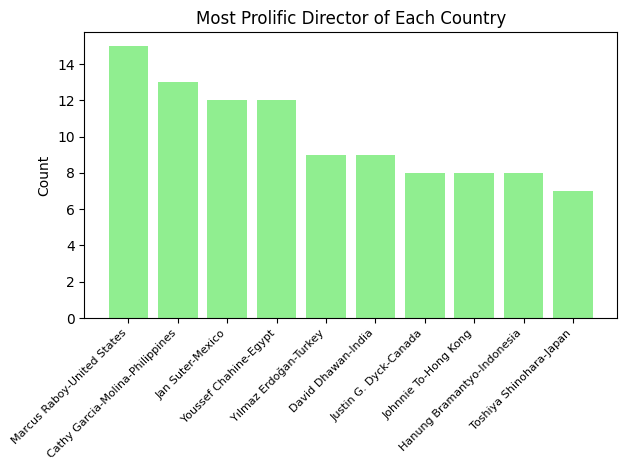

In [6]:
# - Who is/are the most prolific directors for each country?
mask = df_clean['director_list'].notna() & df_clean['country_list'].notna()
directors = df_clean.loc[mask, ['director_list','country_list']].copy()
directors_exploded = directors.explode('director_list').explode('country_list')
director_count = (
    directors_exploded
    .groupby(['director_list','country_list'])
    .size()
    .reset_index(name='count')
)

most_prolific = (
    director_count
    .sort_values('count', ascending=False)
    .groupby('country_list')
    .head(1)
    .reset_index(drop=True)
)
top_10_directors = most_prolific.iloc[:10,:].copy()
top_10_directors['name_country'] = top_10_directors['director_list'] + '-' + top_10_directors['country_list']

plt.bar(x=top_10_directors['name_country'], height=top_10_directors['count'], color='lightgreen')
plt.title('Most Prolific Director of Each Country')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right', fontsize = 8)
plt.tight_layout()

### Q3. Most common cast member?
Based on the finding, Indian and Japanese actors lead the charge as the most common actors on netflix. It was also nice to see Tara Strong, voice actress for Raven on Teen Titans made it on the top 20 list right under Samuel L. Jackson

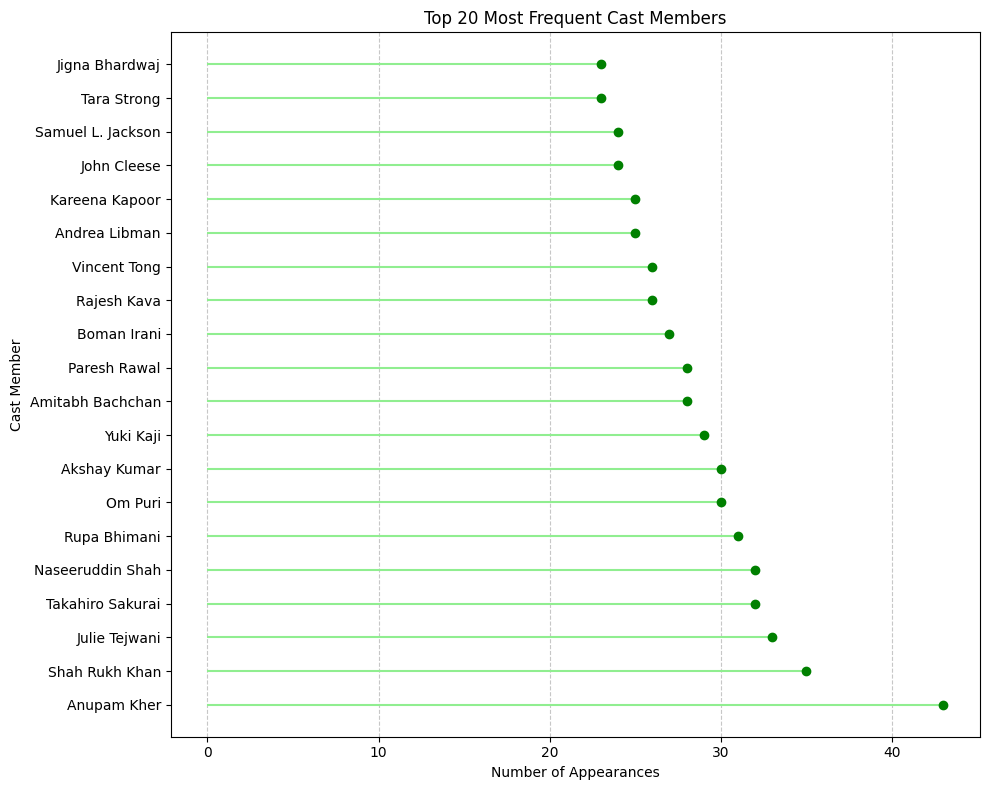

In [7]:
# - Most common cast member?

subset_cast = df_clean['cast_list'].dropna()

cast_exploded = subset_cast.explode('cast_list')
cast_count = cast_exploded.value_counts().reset_index()

top_n = 20
top_cast = cast_count.head(top_n)

plt.figure(figsize=(10,8))
plt.hlines(y=top_cast['cast_list'], xmin=0, xmax=top_cast['count'], color='lightgreen')
plt.plot(top_cast['count'], top_cast['cast_list'], 'o', color='green')

plt.xlabel('Number of Appearances')
plt.ylabel('Cast Member')
plt.title(f'Top {top_n} Most Frequent Cast Members')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Q4. Amount of releases by year split by TV Show and Movie
Netflix is home to some oldies, the tv show "Pioneers: First Women Filmmakers*" from 1925 and two movies from 1942, "Prelude to War" and "The Battle of Midway". After that there are a few sporadic entries, sometimes with multiple year gaps. That is, up until recently where there has been a large boom in visual media, both TV shows and Movies.

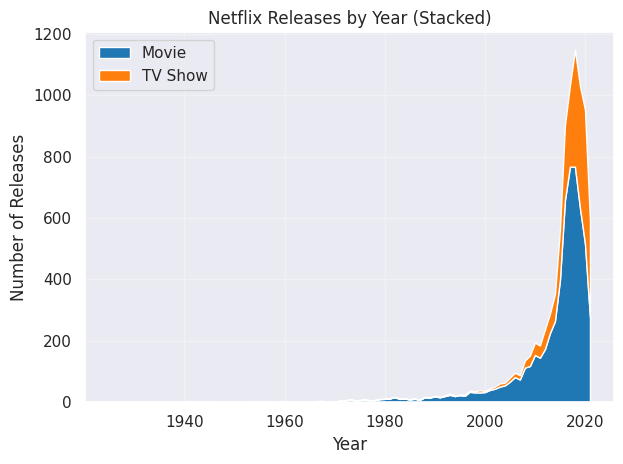

In [8]:
import seaborn as sns

sns.set_theme()
# - Amount of releases by year split by TV Show or Movie
subset_time = df[['type','release_year']].dropna()
release_group = subset_time.groupby(['release_year','type']).size().unstack(fill_value = 0)
release_group_counts = release_group.sort_index()

plt.stackplot(release_group_counts.index,
              release_group_counts['Movie'],
              release_group_counts['TV Show'],
              labels=['Movie', 'TV Show'],
              colors=['#1f77b4', '#ff7f0e']
              )

plt.legend(loc='upper left')
plt.title('Netflix Releases by Year (Stacked)')
plt.xlabel('Year')
plt.ylabel('Number of Releases')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Q5. How long are the movies on average by country and by genre
Looking at just the movies, the longest runtime listed with the Bandersnatch at 312 minutes or just over 5 hours. This didn't make any sense so I looked it up and it's an interactive movie with that much total content.
When considering countries with the longest average runtime of movies, initially Liechtenstein appears to be on top. However since it only has a single entry it can't really be considered an average. Limiting the analysis to only countries with >=3 entries, we see that the Soviet Union leads with an average movie length of 156.7 minutes.

In [22]:
# - How long are the movies on average, by genre or by country?
# Subset to only movies
# Explode by country and genre
df_movie = df_clean[df_clean['type'] == 'Movie'].copy()

df_movie['runtime'] = df_movie['duration'].str.replace('min', "")
df_movie['runtime_int'] = df_movie['runtime'].astype('Int64')

longest_movie = df_movie.sort_values(by='runtime_int', ascending=False).iloc[[0]][['title','runtime_int']]
print("Longest movie", longest_movie)

movie_country = df_movie.explode('country_list').dropna()

mean_duration_country = (
    movie_country
    .dropna(subset=['country_list', 'runtime_int'])  # drop rows with missing country or duration
    .groupby('country_list')['runtime_int']
    .agg(
        Average_Duration='mean',
        Entry_Count='count'
    )
    .sort_values(by='Average_Duration', ascending=False)
    .reset_index()
)
mean_duration_country.columns = ['Country', 'Avg. Duration', 'Count']
mean_duration_country['Avg. Duration'] = mean_duration_country['Avg. Duration'].round(1)

mean_duration_country_sub = mean_duration_country[mean_duration_country['Count']>=3]

mean_duration_country_sub.iloc[:10,:].style.set_caption("Top 10 Countries by Average Movie Duration") \
     .format({'Avg. Duration': '{:.1f}'}) \
     .hide(axis='index') 


Longest movie                            title  runtime_int
4253  Black Mirror: Bandersnatch          312


Country,Avg. Duration,Count
Soviet Union,156.7,3
Morocco,147.4,5
Pakistan,127.9,19
India,127.3,932
Romania,123.8,13
Hungary,113.0,10
Iran,112.2,4
Czech Republic,111.8,15
Philippines,111.1,79
Slovenia,111.0,3


Now looking by genre, we see that classic movies are the longest at 118.6 minutes on average.

In [14]:
# mean_duration
movie_genre = df_movie.explode('listed_in_list')

mean_duration_genre = (
    movie_genre
    .dropna(subset=['listed_in_list', 'duration_int'])  # drop rows with missing genre or duration
    .groupby('listed_in_list')['duration_int']
    .agg(
        Average_Duration='mean',
        Entry_Count='count'
    )
    .sort_values(by='Average_Duration', ascending=False)
    .reset_index()
)

mean_duration_genre.columns = ['Genre', 'Avg. Duration', 'Count']
mean_duration_genre['Avg. Duration'] = mean_duration_genre['Avg. Duration'].round(1)

mean_duration_genre.iloc[:10,:].style.set_caption("Top 10 Countries by Average Movie Duration") \
     .format({'Avg. Duration': '{:.1f}'}) \
     .hide(axis='index') 

Genre,Avg. Duration,Count
Classic,118.6,116
Action & Adventure,113.5,859
Dramas,113.1,2427
Romantic,110.6,616
International,110.3,2752
Thrillers,107.2,577
Music & Musicals,106.1,375
Sci-Fi & Fantasy,106.0,243
Faith & Spirituality,105.6,65
Cult,104.5,71
